# Instrument control
Once you've got data analysis nailed, the next step to being even more powerful with Python is to start automating your experiments. For example, this could allow you to set up experiments to run overnight, analyse themselves, and prepare a report, all while you're at home asleep!

In a typical experimental setup you might have several pieces of apparatus, all made by different companies and no obvious way to communicate between them. Particularly for experiments that you have to repeat fairly regularly where you have several parameters to vary, controlling everything manually will take a lot of your time. The best solution is to write a program to do it for you. What most lab equipment has in common is the ability to accept commands over serial or gpib connections in a standard way. This means a master program that can communicate with these protocals can, in principle, address many instruments together. 

Python can have this ability with the [PyVISA module](https://pyvisa.readthedocs.org/en/stable/index.html). To get the PyVISA module working you should first install the National Instruments VISA library for your operating system: from [here](http://www.ni.com/download/ni-visa-14.0.2/5075/en/) for Mac, from [here](http://www.ni.com/download/ni-visa-5.4.1/4626/en/) for Windows, or from [here](http://www.ni.com/download/ni-visa-5.4.1/4629/en/) for Linux. Then you can install the PyVISA module. Anaconda doesn't come with PyVISA built-in but we can install it with [pip](https://pip.pypa.io/en/stable/). To do so, open the Anaconda prompt or terminal (on Windows search for "Anaconda Prompt" from the start menu). Then type `pip install pyvisa` into the prompt and press return. If you are asked whether to `Proceed?`, confirm the installation by typing `y`. When it's finished, you can check whether PyVISA is available in your environment by typing `conda list` and pressing return. This gives you a list of all your modules and PyVISA should now be one of them.

PyVISA contains a lot of functions but you'll usually only need a small subset of them to issue commands to instruments. However, each instrument most likely requires its own unique set of commands to access its functionality. You have to find these in the documentation for your instrument but often it's not that hard. If your instruments are fairly standard there will usually be examples available online. Here we'll go through a quick example for making I-V sweeps with a Keithley 2614B source measure unit. First we import the module. We'll also include NumPy to manipulate our data matplotlib to plot it. 

In [1]:
%matplotlib inline
import pyvisa
import matplotlib.pyplot as plt
import numpy as np

We need to create a resource manager to access the connected instruments. This allows us to see what's connected to the computer using the `list_resources()` method of the resource manager.

In [2]:
rm = pyvisa.ResourceManager() # Create the resource manager
rm.list_resources()

('GPIB0::26::INSTR',)

Then we can open a connection to the instrument using it's address name and assign the connection to a variable to more easily call methods available to it.

In [3]:
keithley2614B = rm.open_resource(rm.list_resources()[0])

There are essentially three methods we'll use to communicate with an instrument once we've opened the connection: `write`, `read`, and `query`. Let's use a `query` (first writing a command and then reading the response) to find out the identity of our instrument. To get this information from a Keithley 2400 the command it requires is `'*IDN?'`. This is the part that is instrument specific and you need to look it up in the instrument documentation.

In [4]:
keithley2614B.query('*IDN?')

'Keithley Instruments Inc., Model 2614B, 4012211, 3.1.0\n'

To make the Keithey 2400 carry out a voltage sweep, we first need to set up some initial parameters. These are issued using the `write` function. We'll put these in a function as we'll most likely use it again for other programs.

In [5]:
def k2614B_setup(sfunc, mfunc, v_range, i_range, delay):
    """
    Setup the Keithley 2400 for a voltage sweep.
    """
    
    keithley2614B.write('smua.source.output = smua.OUTPUT_OFF') # Disable the output
    keithley2614B.write('smua.source.func = smua.OUTPUT_'+sfunc) # Set source mode to voltage
    keithley2614B.write('display.smua.measure.func = display.MEASURE_DCAMPS') # Set source mode to voltage
    keithley2614B.write('smua.measure.rangev = '+str(v_range)) # Set the voltage range
    keithley2614B.write('smua.measure.rangei = '+str(i_range)) # Set the current range
    keithley2614B.write('smua.measure.delay = '+str(delay)) # Set the delay

Then we can create a function for our main I-V sweep. The Keithley 2400 has a separate command for performing a sweep but as an illustration of how Python can be helpful in instrument control, we'll make ours with a `for` loop as you would if you have more complicated experimental conditions.

In [6]:
def k2614B_iv_sweep(v_sweep):
    """
    Perform a current-voltage list sweep for voltages in v_sweep and return the results
    """
    
    keithley2614B.write('smua.source.output = smua.OUTPUT_ON') # Turn on output
    
    currents = []
    for voltage in v_sweep:
        keithley2614B.write('smua.source.levelv = '+str(voltage)) # Set the voltage
        data = keithley2614B.ask('print(smua.measure.i())') # Measure the current
        currents.append(float(data))
    
    keithley2614B.write('smua.source.output = smua.OUTPUT_OFF') # Disable output after sweep has finished
    
    return currents

Now we can set the conditions that we want to use in our measurement, call our functions, and plot the output.

Resistance = 1747.65426443 ohms


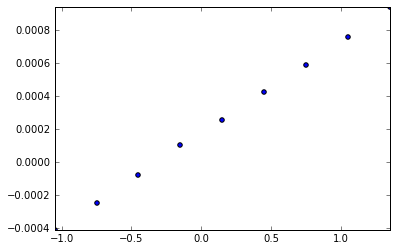

In [7]:
# Settings
sfunc = 'DCVOLTS' # source function is voltage
mfunc = 'DCAMPS' # source function is voltage
v_range = 3 # voltage range
i_range = 0.2 # current range
delay = 1 # source delay
v_sweep = np.arange(-1.05,1.35,0.3)

# Setup Keithley 2614B and perform the sweep
k2614B_setup(sfunc, mfunc, v_range, i_range, delay)
currents = k2614B_iv_sweep(v_sweep)

plt.scatter(v_sweep, currents)
plt.axis([min(v_sweep),max(v_sweep),min(currents),max(currents)])

print('Resistance = '+str(np.mean(v_sweep/currents))+' ohms')

# Other useful stuff to know
## Other packages
We've covered a decent amount of the Python toolkit that's useful for scientists and engineers and it should cover most of your requirements. But that's by no means everything. There are two other packages we haven't had time to look at that I think are the next most useful and may come up in some of your future applications:


* [Pandas](http://pandas.pydata.org/) - This is a package for database management. It's particularly good at handling very large data sets and data sets with mixed data types.


* [SymPy](http://www.sympy.org/en/index.html) - A package for symbolic mathemathics. A bit like Mathematica/Wolfram Alpha, it can solve algebraic expressions symbolically.

## Package management
As we highlighted earlier in the lesson, the Anaconda distribution might not include *everything* you need. There may be times where you need to update/install/uninstall stuff. Managing modules is done in the terminal/command prompt and it's best to use the Anaconda shell (in Windows search for "Anaconda Prompt" from the start menu). The recommended package manager that comes with Anaconda is [Conda](http://conda.pydata.org/docs/). The most useful commands are the following:


* `conda list` - lists all packages installed in the current environment


* `conda search [name]` - check if the package called [name] is available to install from conda (don't include square brackets)


* `conda install [name]` - installs the package called [name]


* `conda remove [name]` - removes the package called [name]


* `conda info [name]` - get info about package called [name]


* `conda update [name]` - update the package called [name]


* `conda update anaconda` - update all packages installed with conda as a stable distribution


Sometimes you can find that a package is not available to install with Conda. This is usually because it hasn't been tested as stable and compatible with the other installed packages. However, that doesn't mean it's not stable. In this case you can try [pip](https://pip.pypa.io/en/stable/), which has access to a much wider range of packages. The command you need is `pip install [name]`. Anything installed with pip should be managed with pip with commands like `pip update [name]`. If you have a problem with one of these packages you can use `pip uninstall [name]`.



## Other tips for IPython/Jupyter
Jupyter offers a lot of other tricks that make your coding more efficient. Here is a complete [manual](http://jupyter.cs.brynmawr.edu/hub/dblank/public/Jupyter%20Notebook%20Users%20Manual.ipynb) if you want to get to know all of its functionality.

### Keyboard shortcuts
For starters, you have several keyboard shortcuts. To find out what they are, click `Help` > `Keyboard Shortcuts` on the toolbar. One of the most useful is tab completion, where you can press tab at any time to get a list of available options depending on what you've already typed. This can be very useful if you have to re-type long variable names, navigate a file path, or see what methods are available to an object.

### Markdown cells
Aside from code cells, Jupyter offers Markdown cells for rich-text allowing you to format your code and comments as an easily readable notebook (like this one!). To convert a code cell to a Markdown cell, press `Esc`, then `m`. For a guide on how to use Markdown in Jupyter you can look [here](http://jupyter.cs.brynmawr.edu/hub/dblank/public/Jupyter%20Notebook%20Users%20Manual.ipynb#4.-Using-Markdown-Cells-for-Writing) or use this [cheat sheet](http://nestacms.com/docs/creating-content/markdown-cheat-sheet). Equations in Markdown can be generated with TeX [commands](http://meta.math.stackexchange.com/questions/5020/mathjax-basic-tutorial-and-quick-reference).

### Raw cells
No rich-text, no syntax highlighting, no execution, just raw text. Press `Esc`, then `r` to make a cell a raw cell.

## Other editors
Some people don't like working in code blocks with IPython/Jupyter and prefer a different style. Two alternatives that are worth a look are:


* [Spyder](https://pythonhosted.org/spyder/) - MATLAB-like enviroment with separate panes for code, output, object inspection. This comes with Anaconda so you should have it already.


* [PyCharm](https://www.jetbrains.com/pycharm/) - Mainly intended for web development but shows input and output, offers lots of features to code efficiently, and looks cool. I haven't used this one but it's worth a try if Jupyter isn't your thing.

## Python style
Python's principle philosophy as a programming language is that the code should be expressive, easy to read, and there should be only one obvious way to do something. If you agree with this philosophy and need a reminder of some guiding principles to follow, Python has something for you.

In [8]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


Or if you want some more concrete advice about conventions, there is an official [style guide](https://www.python.org/dev/peps/pep-0008/).